In [1]:
# 상위 폴더 경로 가져오기.
from example_base import GetParentPath
# 핑퐁 로봇 제어 모듈 import.
from pingpongthread import PingPongThread

In [2]:
# 2개 로봇을 연결하는 인스턴스 생성.
PingPongThreadInstance = PingPongThread(number=2)#, group_id=10)
# 로봇 제어 쓰레드 시작.
PingPongThreadInstance.start()
# 모든 로봇이 연결될 때 까지 기다림.
PingPongThreadInstance.wait_until_full_connect()

Found device: USB 직렬 장치(COM11)
Serial connected.
Write data: FF FF 00 FF 20 00 AD 00 0B 0A 00
Connected with a master robot.
Connected robots: 2
Fully connected.


In [3]:
# 웹캠 열기.
#PingPongThreadInstance.webcam_open(0)
PingPongThreadInstance.webcam_open("http://192.168.66.1:9527/videostream.cgi?loginuse=admin&loginpas=admin")

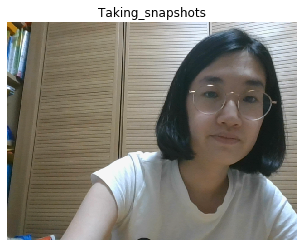

Q hit, closing...


In [6]:
# go 폴더 안에 '전진' 찍기.
PingPongThreadInstance.webcam_take_snapshots("chapter_autocar/go")

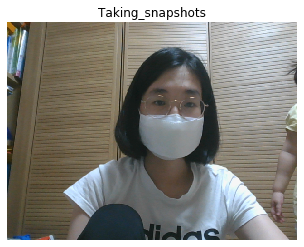

Q hit, closing...


In [7]:
# 오른쪽 찍기.
PingPongThreadInstance.webcam_take_snapshots("chapter_autocar/right")

In [7]:
# 왼쪽' 찍기.
PingPongThreadInstance.webcam_take_snapshots("chapter_autocar/left")

Save images to chapter_autocar/left/
Press S to take a snapshot, or press Q to quit.


In [26]:
# 웹캠 닫기.
PingPongThreadInstance.webcam_close()

In [9]:
# '마스크 안 쓴 사진' 클래스 인스턴스, ''마스크 쓴 사진' 클래스 인스턴스 생성.
no_mask = PingPongThread.ImageClass("no_mask", "chapter_autocar/go")
with_mask = PingPongThread.ImageClass("with_mask", "chapter2/with_mask")

In [10]:
# 모델 트레이닝. 
# 첫 번째 인수는 저장하는 이름, 두 번째 인수는 knn 알고리즘의 k 값, 세 번째 인수는 모델 모드. 네 번째 인수 이후는 클래스 인스턴스들.
model = PingPongThreadInstance.train_classes("chapter2/mask_model.json", 5, 1, no_mask, with_mask)

Class no_mask : 28 images.
Class with_mask : 27 images.
17227776/17225924 [==============================] - 2s 0us/step
Training done.
chapter2/mask_model.json saved.


In [11]:
# 센서 값 받기. 0.5초마다 한 번씩 수신.
PingPongThreadInstance.receive_sensor_data(cube_ID, method="periodic", period=0.5)

Write data: FF FF 10 00 00 C8 B8 00 0B 32 01


In [12]:
# 근접 센서의 디폴트 값 받기. 이 함수를 실행할 때는 근접 센서 앞에 아무것도 없도록 주의.
proxy_default = PingPongThreadInstance.get_default_proxy(cube_ID)

In [13]:
# 시간 제어를 위한 모듈 import.
import time
import numpy


num = 0

# 근접 센서를 체크하는 루프.
while True:
    # 근접 센서 변화량.
    proxy_diff = abs(PingPongThreadInstance.get_current_proxy(cube_ID) - proxy_default)
    # 근접 센서 변화량이 10을 넘으면 3초 쉬고 마스크 검사.
    if 10 < proxy_diff:
        # 센서 데이터 그만 받기.
        PingPongThreadInstance.stop_sensor_data(cube_ID) 
        print("마스크를 검사할게요~.")
        time.sleep(3)
        break
    else:
        print("장애물이 감지되지 않았어요.")
        time.sleep(0.1)
        # 출력 비우기.
        PingPongThreadInstance.clear_output()

Write data: FF FF 10 00 00 C8 B8 00 0B 00 01
마스크를 검사할게요~.


In [14]:
# 웹캠 열기.
PingPongThreadInstance.webcam_open(0)
#PingPongThreadInstance.webcam_open("http://192.168.66.1:9527/videostream.cgi?loginuse=admin&loginpas=admin")

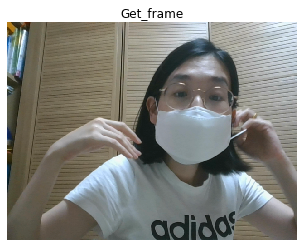

{'no_mask': 0, 'with_mask': 5}
accum_prediction: {'with_mask': 0.8666666666666667, 'no_mask': 0.13333333333333333}
마스크를 잘 착용하고 왔네요~. 등교를 환영합니다!
Write data: FF FF 10 00 10 00 C1 00 13 02 01 00 02 FC 7C 00 00 01 F4
Write data: FF FF 10 00 10 00 C1 00 13 02 01 00 02 03 84 00 00 01 F4


In [15]:
# 프레임을 평가하는 인스턴스 생성. 누적 프레임은 1초 동안 보관.
frames_predictor = PingPongThread.FramesPredictor(model=model, timer_sec=3)
# 웹캠을 이용하여 마스크 착용 여부를 예측하는 루프.
while True:
    # 주피터 노트북 출력 비우기.
    PingPongThreadInstance.clear_output()
    # 현재 웹캠 프레임 가져오기.
    frame = PingPongThreadInstance.webcam_get_frame(window="Get_frame")
    # 현재 프레임을 평가하고, 평가 내용을 누적.
    frames_prediction = frames_predictor.image_predict_and_accum(frame)
    print(frames_prediction)
    # 누적된 평가 내용.
    accum_prediction = frames_predictor.accum_predict()
    # 누적된 평가 내용이 없으면 돌아가기. 아니면 가장 확률이 높은 클래스 확인.
    if accum_prediction == None:
        max_class = None
        continue
    else:
        print("accum_prediction:", accum_prediction)
        # 가장 확률이 높은 클래스.
        max_class = max(accum_prediction, key=accum_prediction.get)
    # 마스크를 착용한 확률이 80% 이상이면 자동문 열림.
    if max_class == "with_mask" and accum_prediction[max_class] > 0.8:
        print("마스크를 잘 착용하고 왔네요~. 등교를 환영합니다!")
        # 15RPM, 시계 반대 방향으로 1/4바퀴(90도) 회전.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, -0.25)
        # 4초 쉼.
        time.sleep(4)
        # 15RPM, 시계 방향으로 1/4바퀴(90도) 회전.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, 0.25)
        break
    else:
        print("이런… 마스크를 깜빡 했나보군요… 마스크를 착용하고 등교해주세요!")

In [8]:
# 웹캠 닫기.
PingPongThreadInstance.webcam_close()
# 로봇 제어 쓰레드 종료.
PingPongThreadInstance.end()

Write data: FF FF FF FF 00 00 A8 00 0A 01
Disconnect master robot.
Serial disconnected. Sleep 3 seconds.
End thread.
